In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
med_charges = pd.read_csv('insurance2.csv')

In [3]:
med_charges.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


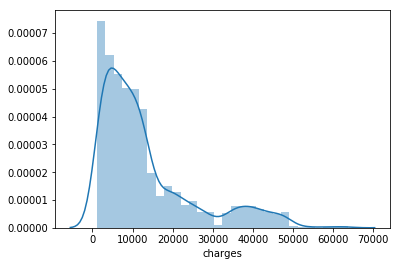

In [4]:
sns.distplot(med_charges.charges)

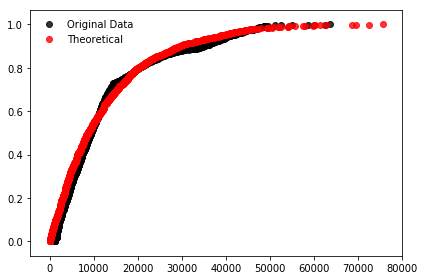

In [5]:
# Function for computing ECDF
np.random.seed(47)
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of observations(n) (needs to be a 1d array)
    n = len(data)
    # x-data
    x = np.sort(data)
    # y-data
    y = np.arange(1, n+1) / n
    return x, y

# Compute and plot ECDF from original data
x, y = ecdf(med_charges.charges)
sns.regplot(x, y, color='black', label='Original Data', fit_reg=False)

# plot cdf of generated data
gen_charge_data = np.random.exponential(scale=np.std(med_charges.charges),
                                        size=len(med_charges.charges))    # np.random.normal == ss.norm.rvs() 
x, y = ecdf(gen_charge_data)
sns.regplot(x, y, color='r', label='Theoretical', fit_reg=False)
plt.legend(frameon=False)
plt.tight_layout()

In [6]:
# Bootstrapping guide

# Single observation (1 charge drawn randomly from sample)
#one_random_observation = np.random.choice(med_charges.charges)
#print('Single charge drawn from sample data: {}'.format(one_random_observation))

# single bootsrap sample drawn from original data with n = 10
#bootstrap_sample = np.random.choice(med_charges.charges, 10)
#print('Single bootstrap sample: {}'.format(bootstrap_sample))

# bootstrap replicate (single value computed from bootstrap sample)
#bs_replicate = np.mean(bootstrap_sample)
#print('Bootstrap replicate: {}'.format(bs_replicate))

Below I will use bootstrap sampling and build a sampling distribution of means from our original data. From the distribution I will estimate the lower limit of a 95% confidence interval.

Sampling distribution of means stats:
(red) Mean 13268.29
(red) + 1 std 13600.3
(red) - 1 std 12936.28

Confidence Interval of Sampling Distribution:
(green) Range at 95% confidence level: 12624.86 - 13918.01
    - upper limit (max charge at 97.5th percentile): 13918.01
    - lower limit (min charge at 2.5th percentile): 12624.86


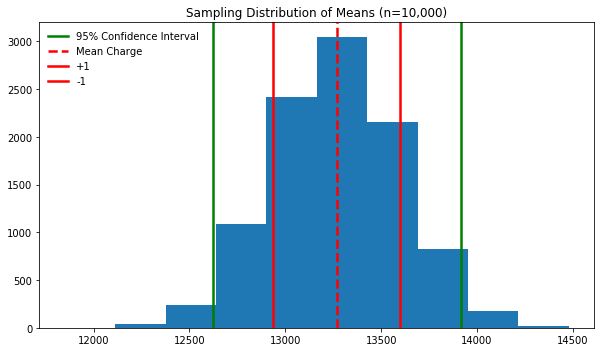

In [7]:
from scipy.stats import norm, t

# Build sampling distribution of the mean from 10,000 boostrap replicates
np.random.seed(47)
N_rep = 10000
n_observations = len(med_charges.charges)
sampdist_ofmeans = [np.mean(np.random.choice(med_charges.charges, n_observations)) for _ in range(N_rep)]

# calculate stats for sampling distribution 
sampdist_meancharge = round(np.mean(sampdist_ofmeans),2)
sampdist_std = round(np.std(sampdist_ofmeans, ddof=1),2)
plus_1_std = round(sampdist_meancharge + sampdist_std,2)
minus_1_std = round(sampdist_meancharge - sampdist_std,2)
print('Sampling distribution of means stats:\n(red) Mean {}\n(red) + 1 std {}\n(red) - 1 std {}\n'.format(sampdist_meancharge,
                                                                                                        plus_1_std,
                                                                                                        minus_1_std))

# Establish significance and confidence levels
alpha = 5
conf_level = 1 - alpha

# Minimum charge at lower limit (2.5%) 
min_charge = round(min(sampdist_ofmeans),2)
lower_p = alpha / 2
lower_lim = max(min_charge, np.percentile(sampdist_ofmeans, lower_p))
print('Confidence Interval of Sampling Distribution:')

# Maximum charge at upper limit (97.5%) 
max_charge = round(max(sampdist_ofmeans),2)
upper_p = (100 - alpha) + (alpha / 2)
upper_lim = min(max_charge, np.percentile(sampdist_ofmeans, upper_p))

#calculate confidence interval for Sampling Distribution of means for medical charges
print('(green) Range at 95% confidence level: {} - {}'.format(round(lower_lim,2), round(upper_lim,2)))
print('    - upper limit (max charge at %.1fth percentile): %.2f' % (upper_p, upper_lim))
print('    - lower limit (min charge at %.1fth percentile): %.2f' % (lower_p, lower_lim))

# plot Sampling Distribution of means and display mean and confidence interval range
fig, ax = plt.subplots(1,1, figsize=(8.5, 5))
plt.hist(sampdist_ofmeans)
plt.title('Sampling Distribution of Means (n=10,000)')
plt.axvline(lower_lim, c='g', lw=2.5, label='95% Confidence Interval')
plt.axvline(upper_lim, c='g', lw=2.5)
plt.axvline(sampdist_meancharge, c='r', ls='--', lw=2.5, label='Mean Charge')
plt.axvline(sampdist_meancharge + sampdist_std, c='r', ls='-', lw=2.5, label='+1')
plt.axvline(sampdist_meancharge - sampdist_std, c='r', ls='-', lw=2.5, label='-1')
plt.legend(frameon=False)
plt.tight_layout()

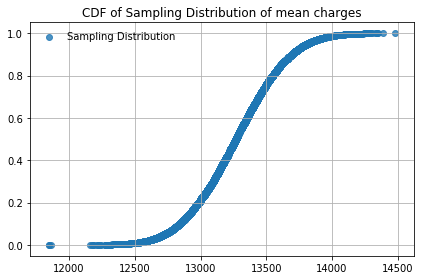

In [8]:
# Compute and plot ECDF from bootstrap sample
x_bs, y_bs = ecdf(sampdist_ofmeans)
sns.regplot(x=x_bs, y=y_bs, label='Sampling Distribution', fit_reg=False)
plt.title('CDF of Sampling Distribution of mean charges')
plt.grid()
plt.legend(frameon=False)
plt.tight_layout()

There are two ways of performing a _t_-test from a sample, depending on whether we can assume the groups have equal variance or not. We can actually easily test this using the bootstrap approach!

__Q:__ Calculate the 95% confidence interval for the difference between the standard deviations of insurance and non-insurance claim charges (insured - non-insured). Calculate the differences over 10000 replicates. Plot the histogram of values and mark the locations of the percentiles. State the null and alternative hypothesis and comment on whether you would retain or reject the null hypothesis in this case and why.

When to use a Paired Samples T-Test:
>"Use this test if you have one group tested at two different times. In other words, you have two measurements on the same item, person, or thing.The groups are “paired” because there intrinsic connections between them (i.e. they are not independent). This comparison of means is often used for groups of patients before treatment and after treatment, or for students tested before remediation and after remediation. - [statisticshowto.com](https://www.statisticshowto.com/probability-and-statistics/t-test/#PairedTTest)

Sample data & statistics (no-claim charges):
Number of observations(n): 555
Mean(xbar): 8821.42
Standard Deviation(s): 6440.7



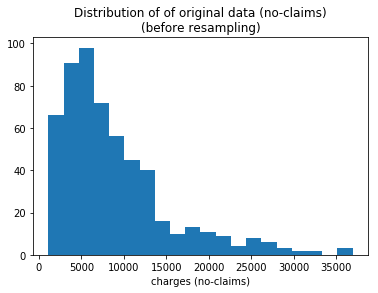


Sampling Distribution of means statistical estimates
Number of bootstraps(B): 10000
Mean(xbar*): 8818.1
Standard Deviation(s*): 272.79


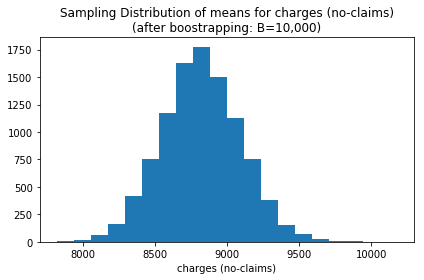

In [9]:
np.random.seed(47)

# data of all original charges with no claims
noclaim_charges = med_charges.loc[med_charges.insuranceclaim == 0, 'charges']
n_noclaim = len(noclaim_charges)
mean_noclaim = round(np.mean(noclaim_charges),2)
s_stat_noclaim = round(np.std(noclaim_charges),2) 
_ = 'Sample data & statistics (no-claim charges):\nNumber of observations(n): {}\nMean(xbar): {}\nStandard Deviation(s): {}\n'
print(_.format(n_noclaim, mean_noclaim, s_stat_noclaim))

plt.hist(noclaim_charges, bins=20)
plt.title('Distribution of of original data (no-claims)\n(before resampling)')
plt.xlabel('charges (no-claims)')
plt.show()

# sampling distribution of means for no claim charges
noclaim_dist_mean = [np.mean(np.random.choice(noclaim_charges, n_noclaim)) for _ in range(10000)]

B = len(noclaim_dist_mean)   # number of samples/resamples: "B"
n = n_noclaim * B            # n observations of sampling dist
mean_noclaim_dist_mean = round(np.mean(noclaim_dist_mean),2)
std_noclaim_dist_mean = round(np.std(noclaim_dist_mean),2)
sampdiststr1 = '\nSampling Distribution of means statistical estimates\nNumber of bootstraps(B): {}\nMean(xbar*): {}\nStandard Deviation(s*): {}'
print(sampdiststr1.format(B, mean_noclaim_dist_mean, std_noclaim_dist_mean))

plt.hist(noclaim_dist_mean, bins=20)
plt.title('Sampling Distribution of means for charges (no-claims)\n(after boostrapping: B=10,000)')
plt.xlabel('charges (no-claims)')
plt.tight_layout()

95% Confidence Interval Estimate: average charge w/o claim.
CI Range: (8090.15 - 9906.02)


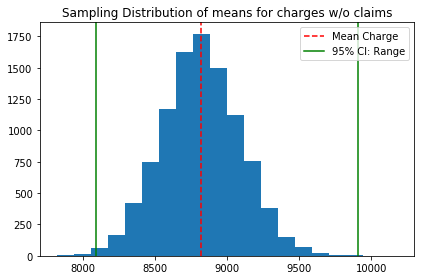

In [10]:
from scipy.stats import norm, t

# Plot Sampling Distribution of means with Confidence Interval for charges (no-claims)
np.random.seed(47)

# 95% confidece level (alpha = .05)
SE = std_noclaim_dist_mean / (n_noclaim - 1)   # Standard Error
df = n_noclaim - 1                 
t_crit = norm.ppf(.95, df)                   # Critical t-value
MOE = t_crit*SE                              # Margin of Error

lower_limit = np.round(noclaim_dist_mean - MOE,2)
lower_cutoff = np.max(lower_limit)
upper_limit = np.round(noclaim_dist_mean + MOE,2)
upper_cutoff = np.min(upper_limit)
print('95% Confidence Interval Estimate: average charge w/o claim.')
print('CI Range: ({} - {})'.format(upper_cutoff, lower_cutoff))

plt.hist(noclaim_dist_mean, bins=20)
plt.title('Sampling Distribution of means for charges w/o claims')
plt.axvline(mean_noclaim_dist_mean, ls='--', c='r', label='Mean Charge')
plt.axvline(lower_cutoff, c='g', label='95% CI: Range')
plt.axvline(upper_cutoff, c='g')
plt.legend(loc='best')
plt.tight_layout()

... Do the same now for charges with claims

Sample data & statistics (claim charges):
Number of observations(n): 783
Mean(xbar): 16423.93
Standard Deviation(s): 14036.96



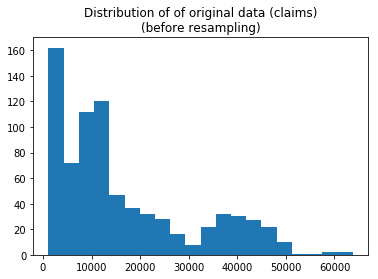


Sampling Distribution of means statistical estimates
Number of bootstraps(B): 10000
Mean(xbar*): 16426.39
Standard Deviation(s*): 496.17


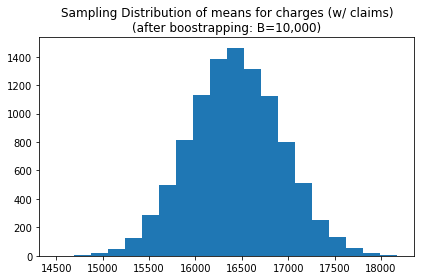

In [11]:
np.random.seed(47)

# data of all original charges with claims
claim_charges = med_charges.loc[med_charges.insuranceclaim == 1, 'charges']
n_claim = len(claim_charges)
mean_claim = round(np.mean(claim_charges),2)
s_stat_claim = round(np.std(claim_charges),2) 
_ = 'Sample data & statistics (claim charges):\nNumber of observations(n): {}\nMean(xbar): {}\nStandard Deviation(s): {}\n'
print(_.format(n_claim, mean_claim, s_stat_claim))

plt.hist(claim_charges, bins=20)
plt.title('Distribution of of original data (claims)\n(before resampling)')
plt.show()

# sampling distribution of means for claim charges
claim_dist_mean = [np.mean(np.random.choice(claim_charges, n_claim)) for _ in range(10000)]

B_claims = len(claim_dist_mean)   # number of samples/resamples: "B"
n = n_claim * B_claims            # n observations of sampling dist
mean_claim_dist_mean = round(np.mean(claim_dist_mean),2)
std_claim_dist_mean = round(np.std(claim_dist_mean),2)
sampdiststr2 = '\nSampling Distribution of means statistical estimates\nNumber of bootstraps(B): {}\nMean(xbar*): {}\nStandard Deviation(s*): {}'
print(sampdiststr2.format(B_claims, mean_claim_dist_mean, std_claim_dist_mean))

plt.hist(claim_dist_mean, bins=20)
plt.title('Sampling Distribution of means for charges (w/ claims)\n(after boostrapping: B=10,000)')
plt.tight_layout()

95% Confidence Interval Estimate: average charge w/o claim.
CI Range: (17820.97 - 14854.87)


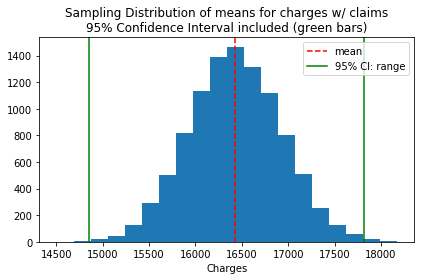

In [12]:
# Plot Sampling Distribution of means with Confidence Interval for charges with claims
np.random.seed(47)

# 95% confidece level (alpha = .05)
SE_ = std_claim_dist_mean / (n_claim - 1)   # Standard Error
df_ = n_claim - 1                 
t_crit_ = norm.ppf(.95, df)                 # Critical t-value
MOE_ = t_crit_*SE_                          # Margin of Error

lower_limit_ = np.round(claim_dist_mean - MOE_,2)
lower_cutoff_ = np.max(lower_limit_)
upper_limit_ = np.round(claim_dist_mean + MOE_,2)
upper_cutoff_ = np.min(upper_limit_)
print('95% Confidence Interval Estimate: average charge w/o claim.')
print('CI Range: ({} - {})'.format(lower_cutoff_, upper_cutoff_))

plt.hist(claim_dist_mean, bins=20)
plt.title('Sampling Distribution of means for charges w/ claims\n95% Confidence Interval included (green bars)')
plt.xlabel('Charges')
plt.axvline(mean_claim_dist_mean, ls='--', c='r', label='mean')
plt.axvline(lower_cutoff_, c='g', label='95% CI: range')
plt.axvline(upper_cutoff_, c='g')
plt.legend()
plt.tight_layout()

Next I will calculate the Confidence Interval for the difference between claim charges and charges without claims.
 as well as visualize graphically the locations of the percentiles.

State the null and alternative hypothesis and comment on whether you would retain or reject the null hypothesis in this case and why.

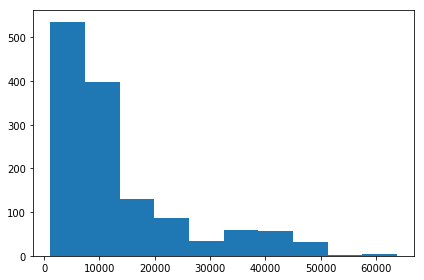

In [13]:
str1 = 'ALL charges from sample: Mean {}, Median {} sd {}.'
str1.format(np.round(np.mean(med_charges.charges),3),
            np.round(np.median(med_charges.charges),3),
            np.round(np.std(med_charges.charges, ddof=1),3))

# plot all charges
plt.hist(med_charges.charges)
plt.tight_layout()

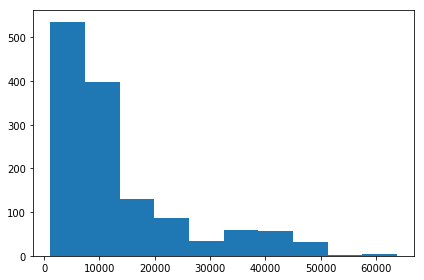

In [14]:
str1 = 'ALL charges from sample: Mean {}, Median {} sd {}.'
str1.format(np.round(np.mean(med_charges.charges),3),
            np.round(np.median(med_charges.charges),3),
            np.round(np.std(med_charges.charges, ddof=1),3))

# plot all charges
plt.hist(med_charges.charges)
plt.tight_layout()

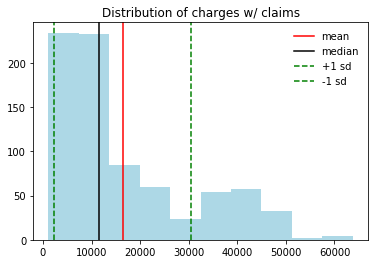

~ Stats for charges w/ claims ~
(above) Original sample mean: 16423.928
(below) Mean of sample from original sample: 16495.912

(above) Original sample median: 11538.421
(below) Median of sample from original sample: 11356.661

(above) Original sample SD: 14045.928
(below) S of sample from original sample: 14326.771


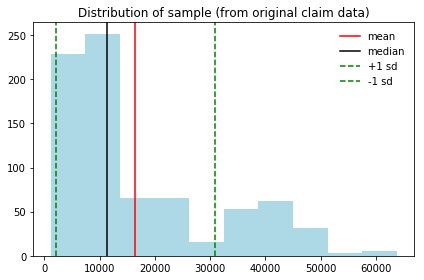

In [15]:
# CHARGES w/ CLAIMS
np.random.seed(47)
claim_charges = med_charges.loc[med_charges.insuranceclaim == 1, 'charges']
claim_charge_size = len(claim_charges)
mean_claim_charge = round(np.mean(claim_charges),3) # population estimate
median_claim_charge = round(np.median(claim_charges),3) # popualtion esitmate
sd_claim_charge = round(np.std(claim_charges, ddof=1),3) # population estimate
var_claim_charge = sd_claim_charge ** 2
# manual calculation of sample standard deviation
deviations_squared = (claim_charges - mean_claim_charge) ** 2
ss = np.sum(deviations_squared)
manual_sd_claims = round(np.sqrt((ss / (claim_charge_size - 1))),3)
# plot (distribution of claim charges)
plt.hist(claim_charges, color='lightblue', histtype='stepfilled')
plt.title('Distribution of charges w/ claims')
plt.axvline(mean_claim_charge, c='r', ls='-', label='mean'); plt.axvline(median_claim_charge, c='black', ls='-', label='median')
plt.axvline((mean_claim_charge + sd_claim_charge), c='g', ls='--', label='+1 sd')
plt.axvline((mean_claim_charge - sd_claim_charge), c='g', ls='--', label='-1 sd')
plt.legend(frameon=False)
plt.show()

# sample of claim charges (from original population sample). Note: "mean_claim_charge" (above) is our pop mean estimate 
sampofsample_claims = np.random.choice(claim_charges, claim_charge_size)
n_sampofsample_claims = len(sampofsample_claims)
mean_sampofsamp_claims = round(np.mean(sampofsample_claims),3)
median_sampofsamp_claims = round(np.median(sampofsample_claims),3)
s_sampofsamp_claims = round(np.std(sampofsample_claims, ddof=2),3)
var_sampofsamp_claims = s_sampofsamp_claims ** 2
print('~ Stats for charges w/ claims ~\n(above) Original sample mean: {}\n(below) Mean of sample from original sample: {}\n'.format(mean_claim_charge, 
                                                                                                                                mean_sampofsamp_claims))
print('(above) Original sample median: {}\n(below) Median of sample from original sample: {}\n'.format(median_claim_charge, median_sampofsamp_claims))
print('(above) Original sample SD: {}\n(below) S of sample from original sample: {}'.format(sd_claim_charge, s_sampofsamp_claims))
# plot(distribution of sample from original claim data)
plt.hist(sampofsample_claims, color='lightblue', histtype='stepfilled')
plt.title('Distribution of sample (from original claim data)')
plt.axvline(mean_sampofsamp_claims, c='r', ls='-', label='mean'); plt.axvline(median_sampofsamp_claims, c='black', ls='-', label='median')
plt.axvline((mean_sampofsamp_claims + s_sampofsamp_claims), c='g', ls='--', label='+1 sd')
plt.axvline((mean_sampofsamp_claims - s_sampofsamp_claims), c='g', ls='--', label='-1 sd')
plt.legend(frameon=False)
plt.tight_layout()

#CI estimation for sample mean, unknown population SD. for t: mean-of-sample-of-sample minus mean-of-sample(mean of sample is pop estimate here for t calc)

# manual attempt at t for x
#diff_0 = round(mean_sampofsamp_claims, mean_claim_charge,3) # -------> Try also: median_sampofsamp_claims - median_claim_charge
#manual_t_for_CI_of_x = ((diff_0) / (s_for_sampofsamp_claims/np.sqrt(n_sampofsample_claims)))

#u = mean_sampofsamp_claims + (t_for_CI_of_x*s_sampofsamp_claims)
#mean_sampofsamp_claims - (t_for_CI_of_x*s_sampofsamp_claims)

#t.cdf()

#df_t_for_x = n_sampofsample_claims - 2
#t_for_CI_of_x = t.ppf(.95, df_t_for_x)
#upp_t_for_CI_of_x = t.ppf(.975, df_t_for_x)
#low_t_for_CI_of_x = t.ppf(.025, df_t_for_x)
#upper_val_x = t.cdf(upp_t_for_CI_of_x, df_t_for_x)
#lower_val_x = t.cdf(low_t_for_CI_of_x, df_t_for_x)
#print('t-value for mean of sample from original sample: {}\nT-value: {}\nCI range for xbar: ({} - {})'.format(t_for_CI_of_x, lower_val_x, upper_val_x))

#mean_sampofsamp_claims + t_for_CI_of_x*

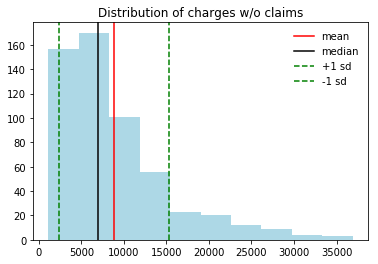

~ Stats for charges w/o claims ~
(above) Original sample mean: 8821.422
(below) Mean of sample from original sample: 8505.251

(above) Original sample median: 6933.242
(below) Median of sample from original sample: 6571.544

(above) Original sample SD: 6446.51
(below) S of sample from original sample: 6170.182


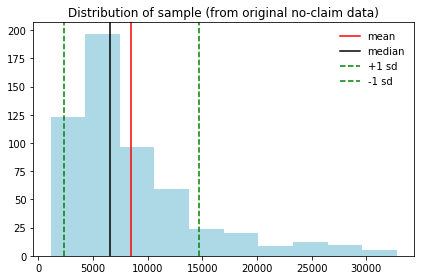

In [16]:
# CHARGES w/o CLAIMS
np.random.seed(47)
noclaim_charges = med_charges.loc[med_charges.insuranceclaim == 0, 'charges']
noclaim_charge_size = len(noclaim_charges)
mean_noclaim_charge = round(np.mean(noclaim_charges),3) # population estimate
median_noclaim_charge = round(np.median(noclaim_charges),3) # popualtion esitmate
sd_noclaim_charge = round(np.std(noclaim_charges, ddof=1),3) # population estimate
var_noclaim_charge = sd_noclaim_charge ** 2
# plot (distribution of no-claim charges)
plt.hist(noclaim_charges, color='lightblue', histtype='stepfilled')
plt.title('Distribution of charges w/o claims')
plt.axvline(mean_noclaim_charge, c='r', ls='-', label='mean'); plt.axvline(median_noclaim_charge, c='black', ls='-', label='median')
plt.axvline((mean_noclaim_charge + sd_noclaim_charge), c='g', ls='--', label='+1 sd')
plt.axvline((mean_noclaim_charge - sd_noclaim_charge), c='g', ls='--', label='-1 sd')
plt.legend(frameon=False)
plt.show()

# sample of no-claim charges (from original population sample). Note: "mean_noclaim_charge" (above) is our pop mean estimate of 2nd population (no-claims)
sampofsample_noclaims = np.random.choice(noclaim_charges, noclaim_charge_size)
n_sampofsample_noclaims = len(sampofsample_noclaims)
mean_sampofsamp_noclaims = round(np.mean(sampofsample_noclaims),3)
median_sampofsamp_noclaims = round(np.median(sampofsample_noclaims),3)
s_sampofsamp_noclaims = round(np.std(sampofsample_noclaims, ddof=2),3)
var_sampofsamp_noclaims = s_sampofsamp_noclaims ** 2
print('~ Stats for charges w/o claims ~\n(above) Original sample mean: {}\n(below) Mean of sample from original sample: {}\n'.format(mean_noclaim_charge, 
                                                                                                                                mean_sampofsamp_noclaims))
print('(above) Original sample median: {}\n(below) Median of sample from original sample: {}\n'.format(median_noclaim_charge, median_sampofsamp_noclaims))
print('(above) Original sample SD: {}\n(below) S of sample from original sample: {}'.format(sd_noclaim_charge, s_sampofsamp_noclaims))
# plot(distribution of sample from original no-claim data)
plt.hist(sampofsample_noclaims, color='lightblue', histtype='stepfilled')
plt.title('Distribution of sample (from original no-claim data)')
plt.axvline(mean_sampofsamp_noclaims, c='r', ls='-', label='mean'); plt.axvline(median_sampofsamp_noclaims, c='black', ls='-', label='median')
plt.axvline((mean_sampofsamp_noclaims + s_sampofsamp_noclaims), c='g', ls='--', label='+1 sd')
plt.axvline((mean_sampofsamp_noclaims - s_sampofsamp_noclaims), c='g', ls='--', label='-1 sd')
plt.legend(frameon=False)
plt.tight_layout()

**Confidence Interval (traditional) for difference between our two groups (charges w/ and without claims)**

In [17]:
# Previously calculated claim & no-claim data
#noclaim_charges = med_charges.loc[med_charges.insuranceclaim == 0, 'charges']
#claim_charges = med_charges.loc[med_charges.insuranceclaim == 1, 'charges']

# CI (traditional method) for difference between two population means (unknown SD, so use t & pooled sd)
from scipy.stats import norm, t
np.random.seed(47)
# pooled Standard deviation of two groups
diff_sample_means = mean_claim_charge - mean_noclaim_charge
print('Mean charge (w/ claims): {}\nMean charge (w/o claims): {}\nDifference between mean charges: {}\n'.format(round(mean_claim_charge,3),
                                                                                                                round(mean_noclaim_charge,3),
                                                                                                                round(diff_sample_means,3)))
df = claim_charge_size + noclaim_charge_size 
t = t.ppf(.95, df)
pooled_se = np.sqrt(((((claim_charge_size -1)*var_claim_charge) + ((noclaim_charge_size -1)*var_noclaim_charge)) / (claim_charge_size + noclaim_charge_size - 2)))

# CI estimation for difference of two means w/ SD unknown
#compute CI upper/lower range: (1.)calculate margin of error, MOE (critcal value (t, unknown) * pooled standard deviation) (2.)+/- difference of means
upper = round(diff_sample_means + (t * (pooled_se * np.sqrt((1/claim_charge_size)+(1/noclaim_charge_size)))),3)
lower = round(diff_sample_means - (t * (pooled_se * np.sqrt((1/claim_charge_size)+(1/noclaim_charge_size)))),3)
print('95% CI for difference between claim & no-claim charges (unknown SD):\nRange: ({} - {})'.format(lower, upper))

Mean charge (w/ claims): 16423.928
Mean charge (w/o claims): 8821.422
Difference between mean charges: 7602.506

95% CI for difference between claim & no-claim charges (unknown SD):
Range: (6550.344 - 8654.668)


**Now, compute the CI with Bootstrapping for each group (charges w/ & w/o claims), followed by difference of means between the groups via bootstrapping.**

~ Sampling distribution of means for charges w/ claims ~
  Average Charge: 16426.385
  Standard deviation: 496.175
  Median Charge (50th Percentile): 16423.820

  Confidence Interval, 2.5th percentile - 97.5th percentile: (15462.590 - 17405.786)


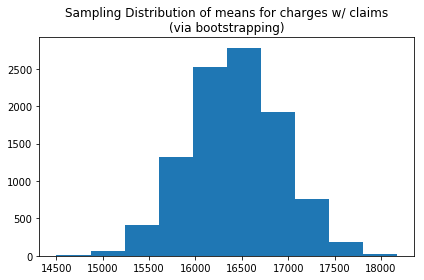

In [18]:
# CI via Bootstrapping for charges with Claims
np.random.seed(47)
n_bs_samples_claims=10000
sampling_distribution_means_claims = list()
for _ in range(n_bs_samples_claims):
    # bootstrap sample
    sample_claims = np.random.choice(claim_charges, claim_charge_size)    #(original sample data, n observations)
    # calculate and store statistic also referred to as "bootstrap replicate", n times ('n' determined by n in range(n))
    bs_replicate_claims = np.mean(sample_claims)
    sampling_distribution_means_claims.append(bs_replicate_claims)    # store statistic for n replicates 

SD_sampling_distribution_means_claims = np.std(sampling_distribution_means_claims)
# confidence interval at 95% confidence level (100 - alpha) for charges with claims
alpha = 5.0
# calculate lower percentile (e.g. 2.5)
lower_p = alpha / 2.0
# retrieve observation at lower percentile
lower = np.percentile(sampling_distribution_means_claims, lower_p)
# calculate upper percentile (e.g. 97.5)
upper_p = (100 - alpha) + (alpha / 2.0)
# retrieve observation at upper percentile
upper = np.percentile(sampling_distribution_means_claims, upper_p)
mid = np.median(sampling_distribution_means_claims)
print('~ Sampling distribution of means for charges w/ claims ~\n  Average Charge: %.3f\n  Standard deviation: %.3f' %(np.mean(sampling_distribution_means_claims),
                                                                                                                            SD_sampling_distribution_means_claims))
_ = '  Median Charge (50th Percentile): %.3f\n\n  Confidence Interval, %.1fth percentile - %.1fth percentile: (%.3f - %.3f)'
print(_%(mid, lower_p, upper_p, lower, upper))

plt.hist(sampling_distribution_means_claims)
plt.title("Sampling Distribution of means for charges w/ claims\n(via bootstrapping)")
plt.tight_layout()

~ Sampling distribution of means for charges w/o claims ~
  Average Charge: 8818.096
  Standard deviation: 272.794
  Median Charge (50th Percentile): 8814.440

  Confidence Interval, 2.5th percentile - 97.5th percentile: (15462.590 - 9355.051)


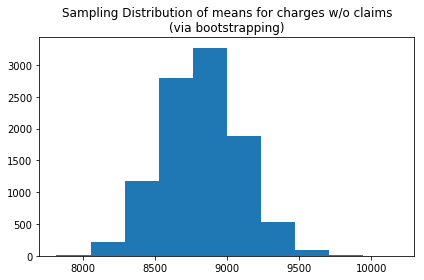

In [19]:
# CI via Bootstrapping for charges with without Claims
np.random.seed(47)
n_bs_samples_noclaims=10000
sampling_distribution_means_noclaims = list()
for _ in range(n_bs_samples_noclaims):
    # bootstrap sample of no-claim charges
    sample_noclaims = np.random.choice(noclaim_charges, noclaim_charge_size)    #(original sample data, n observations)
    # calculate and store statistic also referred to as "bootstrap replicate", n times ('n' determined by n in range(n))
    bs_replicate_noclaims = np.mean(sample_noclaims)
    sampling_distribution_means_noclaims.append(bs_replicate_noclaims)    # store statistic for n replicates 
    
SD_sampling_distribution_means_noclaims = np.std(sampling_distribution_means_noclaims)
# confidence interval for 95% confidence level (100 - alpha)
alpha = 5.0
# calculate lower percentile (e.g. 2.5)
lower_p_noclaims = alpha / 2.0
# retrieve observation at lower percentile
lower_noclaims = np.percentile(sampling_distribution_means_noclaims, lower_p_noclaims)
# calculate upper percentile (e.g. 97.5)
upper_p_noclaims = (100 - alpha) + (alpha / 2.0)
# retrieve observation at upper percentile
upper_noclaims = np.percentile(sampling_distribution_means_noclaims, upper_p_noclaims)
mid_noclaims = np.median(sampling_distribution_means_noclaims)
print('~ Sampling distribution of means for charges w/o claims ~\n  Average Charge: %.3f\n  Standard deviation: %.3f' %(np.mean(sampling_distribution_means_noclaims),
                                                                                                                                SD_sampling_distribution_means_noclaims))
_noclaims = '  Median Charge (50th Percentile): %.3f\n\n  Confidence Interval, %.1fth percentile - %.1fth percentile: (%.3f - %.3f)'
print(_noclaims%(mid_noclaims, lower_p_noclaims, upper_p_noclaims, lower, upper_noclaims))

plt.hist(sampling_distribution_means_noclaims)
plt.title("Sampling Distribution of means for charges w/o claims\n(via bootstrapping)")
plt.tight_layout()

**Confidence Interval via bootstrapping for difference between our two groups (charges w/ and without claims)**

In [20]:
# no-claim data Data
n_sampdistmeans_noclaims = len(sampling_distribution_means_noclaims)
mean_sampdistmeans_noclaims = np.mean(sampling_distribution_means_noclaims)
var_sampdistmeans_noclaims = SD_sampling_distribution_means_noclaims ** 2

# claim data
n_sampdistmeans_claims = len(sampling_distribution_means_claims)
mean_sampdistmeans_claims = np.mean(sampling_distribution_means_claims)
var_sampdistmeans_claims = SD_sampling_distribution_means_claims ** 2

# CI (traditional method) for difference between two population means (unknown SD, so use t & pooled sd)
from scipy.stats import norm, t
np.random.seed(47)
# pooled Standard deviation of two groups
diff_means_ofsampdistmeans = mean_sampdistmeans_claims - mean_sampdistmeans_noclaims
df_sampdists = n_sampdistmeans_claims + n_sampdistmeans_noclaims
t = t.ppf(.95, df_sampdists)
pooledse_numerator = np.sqrt(((n_sampdistmeans_claims -1)*var_sampdistmeans_claims)+((n_sampdistmeans_noclaims-1)*var_sampdistmeans_noclaims))
pooled_se_sampdists = pooledse_numerator/(n_sampdistmeans_claims + n_sampdistmeans_noclaims - 2)

# CI estimation for difference between means of sampling distributions of means w/ SD unknown
#compute CI upper/lower range: (1.)calculate margin of error, MOE (critcal value (t, unknown) * pooled standard deviation) (2.)+/- difference of means
upper_sampdistmeans = round(diff_sample_means + (t * (pooled_se_sampdists * np.sqrt((1/n_sampdistmeans_claims)+(1/n_sampdistmeans_noclaims)))),3)
lower_sampdistmeans = round(diff_sample_means - (t * (pooled_se_sampdists * np.sqrt((1/n_sampdistmeans_claims)+(1/n_sampdistmeans_noclaims)))),3)
_sampdistmeans='95% CI for difference between means for our two sampling distributions of means for claim & no-claim charges (unknown SD):\nRange: ({} - {})'
print(_sampdistmeans.format(lower_sampdistmeans, upper_sampdistmeans))

95% CI for difference between means for our two sampling distributions of means for claim & no-claim charges (unknown SD):
Range: (7602.44 - 7602.572)


__Q:__ Calculate the 95% confidence interval for the difference between the standard deviations of insurance and non-insurance claim charges (insured - non-insured). Calculate the differences over 10000 replicates.

State the null and alternative hypothesis and comment on whether you would retain or reject the null hypothesis in this case and why.

**NOTES**

#FOR INDEPENDANT
#from scipy.stats import ttest_ind
#Calculate the T-test for the means of *two independent* samples of scores
#Signature: ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate')

#FOR PAIRED/DEPENDANT
from scipy.stats import ttest_rel

#Paired Sample T-Test: ss.ttest_rel(a=sample1, b=sample2, nan_policy=)

#This is a two-sided test for the null hypothesis,
#that 2 related or repeated samples have identical average (expected) values.
#Returns: (t-statistic, two-sided p value)

np.random.seed(12345678) # fix random seed to get same numbers

rvs1 = norm.rvs(loc=5,scale=10,size=500)

rvs2 = (norm.rvs(loc=5,scale=10,size=500) + norm.rvs(scale=0.2,size=500))
t, p = ttest_rel(rvs1,rvs2)


rvs3 = (norm.rvs(loc=8,scale=10,size=500) + norm.rvs(scale=0.2,size=500))
t_, p_ = ttest_rel(rvs1,rvs3)

print('(blue)   rvs1: mean {}, std {}\n(orange) rvs2: mean {}, std {}\n(green)  rvs3: mean {}, std {}\n'.format(round(np.mean(rvs1),2), round(np.std(rvs1),2),
                                                                                  round(np.mean(rvs2),2), round(np.std(rvs2),2),
                                                                                  round(np.mean(rvs3),2), round(np.std(rvs3),2)))
print('rvs1 and rvs2 t {}, p {}'.format(round(t,2), round(p,2)))
print('rvs1 and rvs3 t {}, p {}'.format(round(t_,2), round(p_,2)))

plt.hist(rvs1, label='rvs1')
plt.show
plt.hist(rvs2, label='rvs2')
plt.show
plt.hist(rvs3, label='rvs3')
plt.legend()
plt.tight_layout()